# 🔲 Regularization in Logistic Regression 

**Regularization** refers to techniques that are used to calibrate machine learning models in order to minimize the adjusted loss function and prevent overfitting or underfitting. Using Regularization, we can fit our machine learning model appropriately on a given test set and hence reduce the errors in it.

<center><img src="images/regularization.png" width=1100></center>

In this notebook, we would like to make a binary classification using regression.

In order to do so, we would like to explore a dataset representing the commercialization of a product given two quality tests performed on that latest.

Since we already made a gradient descent algorithm for Logistic Regression on our <a href="https://github.com/kawaremu/MLFromScratch/blob/main/Logistic%20Regression.ipynb">previous notebook</a>, we are going to add a regularization feature to it.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [9]:
df_products = pd.read_csv('data/products.csv')
df_products.head()

,test1,test2,commercialized
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [10]:
features = ['test1', 'test2']
target = 'commercialized'

In [13]:
X = df_products[features].values
y = df_products[target].values.astype(np.int32).reshape(-1,1)
X.shape,y.shape

((118, 2), (118, 1))

In [14]:
X[:5],y[:5]

(array([[ 0.051267,  0.69956 ],
        [-0.092742,  0.68494 ],
        [-0.21371 ,  0.69225 ],
        [-0.375   ,  0.50219 ],
        [-0.51325 ,  0.46564 ]]),
 array([[1],
        [1],
        [1],
        [1],
        [1]]))

# 🦮 Data Exploration

A machine learning model and conclusions cannot be made without exploration and visualisation.


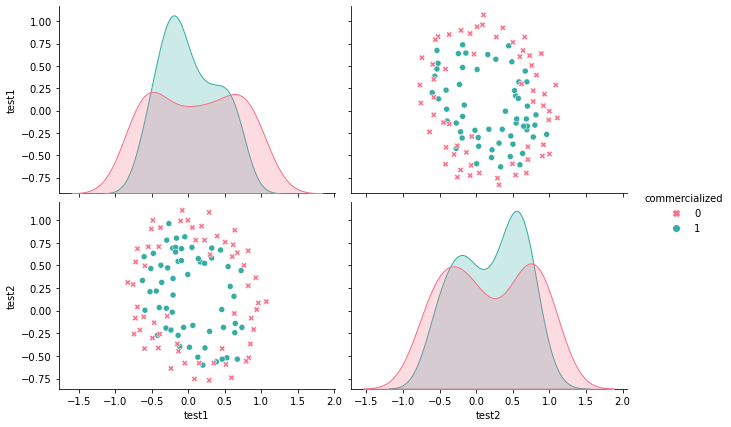

In [5]:
sns.pairplot(df_products, hue='commercialized', height=3,aspect=1.5, palette="husl",markers=["X", "o"])

<AxesSubplot:xlabel='commercialized', ylabel='count'>

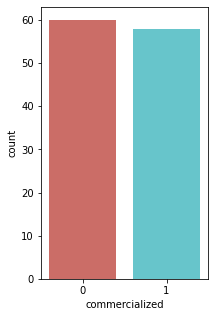

In [7]:
plt.figure(figsize=(3,5))
sns.countplot(x='commercialized',data=df_products,palette='hls')

Let's reuse the functions we made on the previous notebook.

Since we are dealing with a regression problem, we will always need a column of ones stacked to our features that will be multipied by the biais $\theta_{0}$. 

In [8]:
def add_theta_0(X):
  intercept = np.ones(len(X))
  return np.vstack((intercept, X.T)).T

As for every regression problem, weight parameters need to be initialized.

In [15]:
def initialize_theta(n_features,is_random=True):
  """
  Returns bias (intercept) and weight for a vector X of n features in the form of a ndarray [theta_0,theta_1,..., theta_n].
  theta_0 being the bias, and the others the weights.
  n has to be greater or equal to 1.
  
  Parameters:
  n_features: number of features of X. If errors occur, reshape(-1,1) your vector.
  is_random: if set to False, will set values of bias and theta to zero.
  """
  if is_random:
    return np.random.rand(n_features,1) 
  else:
    return np.zeros(shape=(n_features,1))

# Transformation de données
Dans cette partie, nous aimerions transformer nos données afin d'avoir une fonction polynomiale de degrée 6.

La fonction sera:

$x_0=1$

$x_1=x_1$

$x_2=x_2$

$x_3={x_1}^2$

$x_4={x_1}x_2$

$x_5={x_2}^2$

$x_6={x_1}^3$

$x_7={x_1}^2 x_2$

$x_8= x_1 {x_2}^2$

$x_9= {x_2}^3$

...


Pour un polynme de degrée 6 à 2 variables nous aurons 28 caracteristiques

**Question**: comment avons nous trouvé ce chiffre?

**Astuce**: référez vous aux probabilités

In [73]:
def mapping(X):
    
    cols = 28
    degree=7
    outX= np.ones((X.shape[0],cols))
    X1=X[:,1]
    X2=X[:,2]
    k=0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1,i-j)*(np.power(X2,j));
            k=k+1
    return outX    


In [74]:
X2=mapping(X)
X2.shape

(118, 28)

# Descente du Gradient : Préparation des fonctions

0- Fonction mpgistique (Sigmoid)

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

assert sigmoid(0) == 0.5

1- Calcul du coût

Cette fonction servira à calculer le cout $J(\theta_0,\theta_1)$

Elle prendra l'ensemble de données d'apprentissage en entrée ainsi que les paramètres définis initialement

In [17]:
def h_theta(X,theta):
  return sigmoid(X.dot(theta))

In [18]:
def get_cost(X,y,theta):  
       
    m = len(y)

    # Calculate h = X * theta 
    h = h_theta(X,theta)
    
    return -1/m * np.sum((y * np.log(h) + (1 - y) * np.log(1 - h)))

2- Fonction de la descente du gradient

Cette fonction mettra à jour les paramètres $\theta_0,\theta_1$ jusqu'à convergence: atteinte du nombre d'itérations max, ou dérivée assez petite.

In [19]:
import time
def gradient_descent(X, y, theta, num_iters=100, alpha=0.0001,verbose=False):
  '''
  Parameters:
  X : training samples
  y : training labels
  num_iters : epoches of the algorithm to reach convergence
  alpha: step of the partial derivatives
  verbose : if set to True, will log the values of the cost and theta values.
  
  Returns theta updated values, cost_history and theta history.
  '''
  
  # Number of training examples
  m = len(y)
                    
  # History of costs
  result_idx = 0
  gd_iterations_df = pd.DataFrame(columns=['iteration','cost']) 
  J_history = [] 
  theta_history = []
  parameters_out = {}
  
  # Append the initial cost
  gd_iterations_df.loc[result_idx]=[0,get_cost(X,y,theta)]
  result_idx += 1
  
  start = time.time()
  for i in range(1,num_iters+1):
    
      # Step 1 : Calculate h = sigmoid(X * theta)
      h = h_theta(X,theta)
      
      # Step 2 :Calculate the error = (h - y) 
      error = np.subtract(h, y)
      
      # Step 3 : Calculate the new theta
      theta_new = alpha * 1/m * np.sum(np.dot(X.T, error),axis=1).reshape(-1,1)
      # Step 4 : Update theta
      theta = np.subtract(theta, theta_new)

      # Step 5 : Compute the cost to keep history of it
      cost = get_cost(X,y,theta)
      
      gd_iterations_df.loc[result_idx]=[i,cost]
      result_idx += 1
      
      J_history.append(cost)
      theta_history.append(theta.tolist())
      
      if verbose:
          print('{}/{} [>==================]  - loss: {:.2f} - theta = {}'.format(i+1,num_iters,cost,theta))
          
  print('Time spent: {:0.2f}s'.format(time.time()-start))
  parameters_out["bias"] = theta[0][0]
  parameters_out["weight"] = theta[1:]
  return parameters_out,theta, theta_history, J_history,gd_iterations_df 

# Descente du Gradient : Appel des fonctions

Initialisation de $\theta_0$ et $\theta_1$

In [112]:
theta = initialize_theta(X.shape[1],is_random=False)
theta

array([[0.],
       [0.],
       [0.]])

Calculer le cout initial

In [120]:
initial_cost = compute_cost(X,y,theta)
print('initial cost: ',initial_cost)

180000.0


Appel des la fonction de calcul du gradient

In [ ]:
# paramètres
iterations = 1500;
alpha = 0.01;

# paramètre de regression
lambdaa = 1;

# Appel
theta = gradientDescent(X, y, theta, alpha, iterations);

Traçage de la fonction du coût

Notons que $\theta^T  x$ est équivalent à $X  \theta $ où $X= \begin{pmatrix}
..(x^{(1)})^T..\\
..(x^{(2)})^T..\\
.\\
.\\
.\\
..(x^{(m)})^T..
\end{pmatrix} $

# Dessin de la limite de decision (Descision Boundary)
Dans cette partie, nous aimerions dessiner la ligne separatrice d nos données

In [ ]:
def drawCircle():
    pass

# Classification (Prédiction)
Ici il serait interessant de calculer la prédiction en utilisant un seuil
i.e. si h>seuil alors classe =1 sinon classe = 0

In [ ]:
def predict(X):
    return y_pred


# Affichage 
Graphe representant les acceptations selon les caracteristiques

Text(0, 0.5, 'x 2')

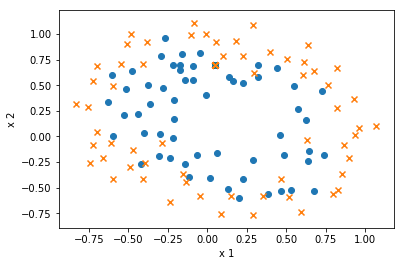

In [12]:
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="y=1",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="y=0",marker ='x')

plt.xlabel('x 1')
plt.ylabel('x 2')

Traçage du coût en fonction de theta0 et theta1

# Qualité du classifieur

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec 

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [78]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(X)
prcision = np.mean(y==y_pred)*100

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 01 Avril 2022 à 22h


In [ ]:
# bonne chance